# Feature development notebook

## 1. Background and object probability density function estimation

Image segmentation requires some knowledge of the background and intensity probability density functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob

from skimage.io import imread

from scipy.stats import *

In [2]:
def computeHist(image_list, correct=False, bp=np.ones(96), at=np.ones(512)):
    N = len(image_list)
    h = np.zeros(255)
    bins = bins = np.arange(0,256)
    x = np.array([])
    
    for idx in range(0,N):
        # read image
        image = imread(image_list[idx],as_grey = True)
#         if correct:
#             image = removeBPR(image, bp, at)
        x = np.hstack((x,image.flatten()))
        # compute histogram
        hi = np.histogram(image[:],bins)

        # add it to total
        h += hi[0]
        
    return (h, bins, x) 

In [22]:
image_list_1 = glob('/home/pvt/Workspace/multibeam-classification/dataset-1/*raw.png')
print len(image_list_1)
image_list_2 = glob('/home/pvt/Workspace/multibeam-classification/dataset-2/*raw.png') # window set to 2.25m to 11.25m
print len(image_list_2)
image_list_3 = glob('/home/pvt/Workspace/multibeam-classification/dataset-3/*raw.png') # 
print len(image_list_3)
image_list_4 = glob('./data/DIDSON/2016-07-19.11/*raw.png') # 
print len(image_list_4)

# background
h_test, h_test_bins, x_test = computeHist(image_list_1)

# background
h_bg, h_bg_bins, x_bg = computeHist(image_list_2)


# test 
# N = 2*len(image_list_3)
# image_list = np.array(image_list_4)
# idx = np.random.randint(0, len(image_list), N)
# h_test, h_test_bins, x_test = computeHist(image_list[idx])

10
116
270
41487


In [25]:
kde_bg = gaussian_kde(x_bg)
kde_test = gaussian_kde(x_test)

x_eval = np.arange(0.0, 256.0,5)

p_bg_kde = kde_bg(x_eval)
p_test_kde = kde_test(x_eval)

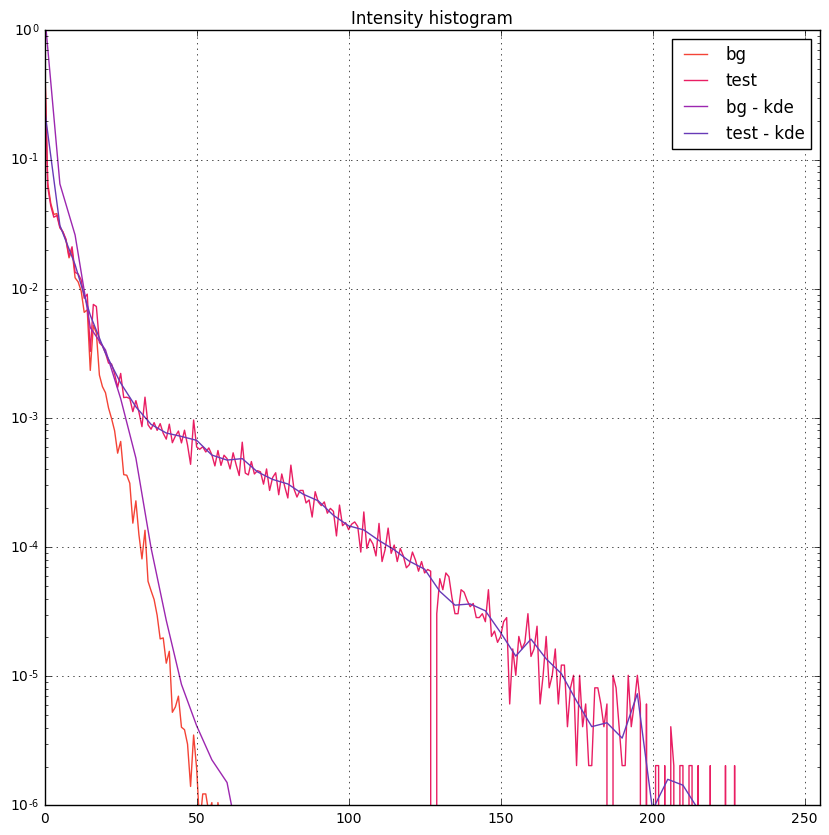

In [26]:
plt.figure(figsize=(10,10))
plt.plot(h_bg_bins[:-1], h_bg/np.sum(h_bg),color='#f44336')
plt.plot(h_test_bins[:-1], h_test/np.sum(h_test),color='#e91e63')



plt.plot(x_eval, p_bg_kde,color='#9c27b0')
plt.plot(x_eval, p_test_kde,color='#673ab7')

plt.yscale('log')
plt.grid()
plt.title('Intensity histogram')
plt.xlim([0,255])
plt.ylim([1e-6,1e0])
plt.legend(('bg','test','bg - kde','test - kde'))

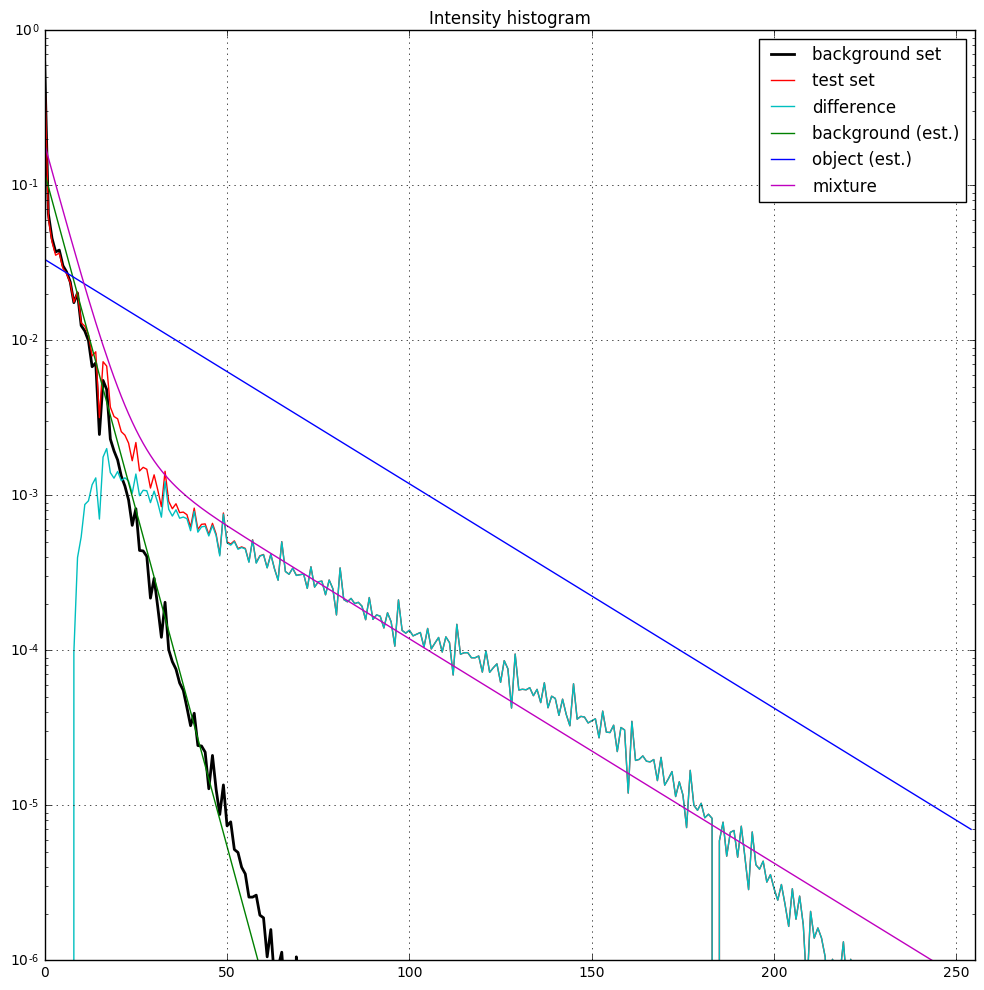

In [4]:
plt.figure(figsize=(12,12))

# background set
plt.plot(h_bg_bins[:-1], h_bg/np.sum(h_bg),color='k',linewidth=2.0)
# test set
plt.plot(h_test_bins[:-1], h_test/np.sum(h_test),color='r')
# difference
plt.plot(h_test_bins[:-1], (h_test/np.sum(h_test)) - (h_bg/np.sum(h_bg)),color='c')

# figure setup
plt.xlim([0,255])
plt.ylim([1e-6,1e0])
plt.yscale('log')
plt.grid()
plt.title('Intensity histogram')

# pdf estimates
de_bg = expon.pdf(h_bg_bins[:-1],0, 5)
plt.plot(h_bg_bins[:-1], 0.6*de_bg,color='g') # note the factor - will not integrate to 1
de_obj = expon.pdf(h_test_bins[:-1],0, 30.0)
plt.plot(h_test_bins[:-1], de_obj,color='b')
plt.plot(h_test_bins[:-1], 0.9*de_bg + 0.1*de_obj,color='m')

plt.legend(('background set','test set','difference','background (est.)','object (est.)','mixture'))

In [ ]:
plt.plot(h_bg_bins[:-1], (h_bg/np.sum(h_bg)),color='k',linewidth=2.0)
# test set
plt.plot(h_test_bins[:-1], (h_test/np.sum(h_test)) - (h_bg/np.sum(h_bg)),color='r')

# figure setup
plt.xlim([0,255])
plt.ylim([1e-6,1e0])
plt.yscale('log')
plt.grid()
plt.title('Intensity histogram')

## 2. Receiver Operating Characteristic

Using the probability density function estimates for background and object, we can compute the ROC curve.

In [ ]:
ilambda_bg = 5.0
ilambda_obj = 30.0

fpv = np.zeros(256)
tpv = np.zeros(256)

for t in range(0,256,1):
    threshold = (t+0.0)
    
    tn = expon.cdf(threshold, loc=0, scale=ilambda_bg)  # background
    fn = expon.cdf(threshold, loc=0, scale=ilambda_obj) # object
    fp = 1 - expon.cdf(threshold, loc = 0, scale = ilambda_bg)
    tp = 1 - expon.cdf(threshold, loc = 0, scale = ilambda_obj)
#     print tn+fp, fn + tp    
    fpv[t] = fp/(fp+tn)
    tpv[t] = tp/(tp+fn)
    if (fp > 1e-2):
        print "%03.2f: %.4f / %.4f" % (threshold, fp, tp)

print '--------------------------'
print "Area under ROC curve: %.2f" % (np.trapz(tpv[::-1],fpv[::-1] ))
    
plt.figure()
plt.plot([0,1],[0,1],'k')
plt.plot(fpv,tpv,'r',marker='.')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('p(fp)')
plt.ylabel('p(tp)')
plt.title('ROC curve')
plt.plot(fpv[23],tpv[23],marker='o')

plt.grid()



In [ ]:
threshold = 20.0

ilambda_bg = 5.0
ilambda_obj = 30.0

print threshold/255.0
a = expon.cdf(threshold, loc=0, scale=ilambda_bg)  # background
b = expon.cdf(threshold, loc=0, scale=ilambda_obj) # object
p = a/(a+b)
c = 1 - expon.cdf(threshold, loc = 0, scale = ilambda_bg)
d = 1 - expon.cdf(threshold, loc = 0, scale = ilambda_obj)
q = d/(c+d)
print p
print q

In [ ]:
# out = expon.fit(x)
print 'params:',out
plt.plot(h_bins[:-1], h/np.sum(h),color='k')
# de = expon.pdf(h_bins[:-1],out[0], out[1])
de = expon.pdf(h_bins[:-1], 0, 4.0)
plt.plot(h_bins[:-1],de,color='g')
plt.grid()
plt.xlim([0,50]) 

In [ ]:
out = weibull_min.fit(x)
print 'weibull_min:',out
de = weibull_min.pdf(h_bins[:-1],out[0],out[1])
plt.plot(h_bins[:-1], h/np.sum(h),color='k')
plt.plot(h_bins[:-1],de,color='r')

## 2. Segmentation using Markov Random Fields

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob

from skimage.io import imread
from scipy.signal import convolve2d

from scipy.stats import expon

# from scipy.optimize import curve_fit
# from scipy.stats import cauchy, chi2, erlang, expon, genexpon, ncx2, poisson, powerlaw, rayleigh

10
0 137


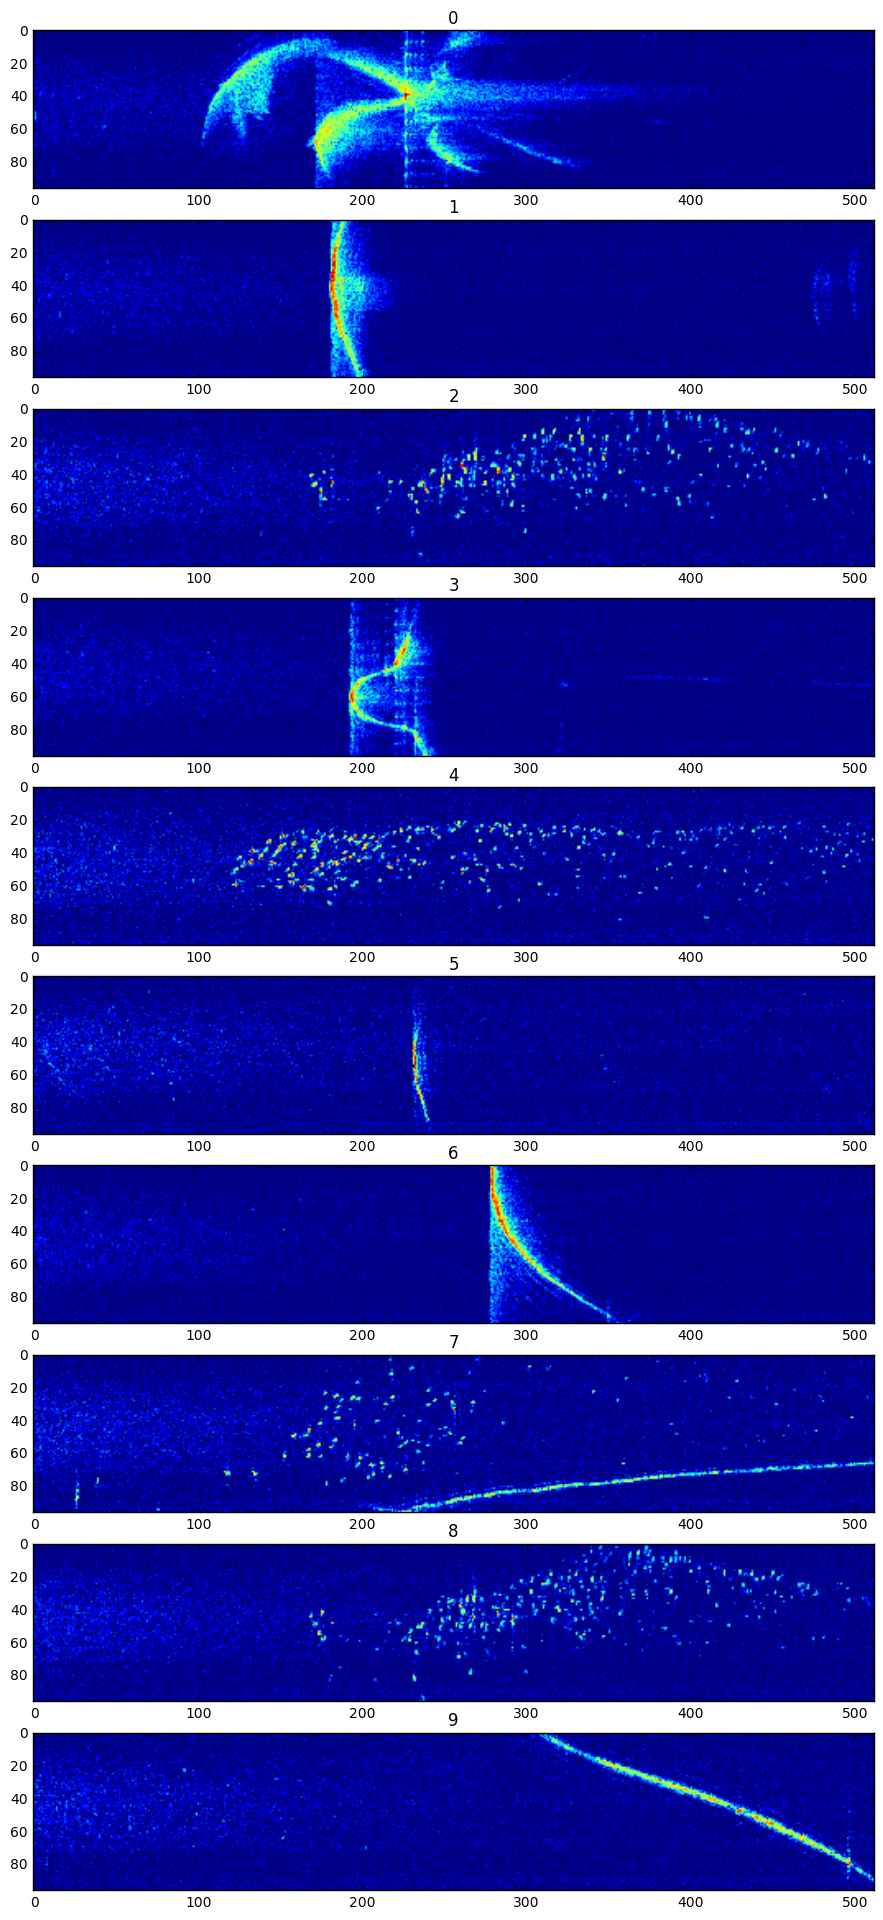

In [3]:
image_list = glob('/home/pvt/Workspace/multibeam-classification/dataset-1/*raw.png') # window set to 2.25m to 11.25m
print len(image_list)

plt.figure(figsize=(48,24))
for i in range(0,10):
    
    img = imread(image_list[i], as_grey=True)
    plt.subplot(10,1,i+1)
    plt.imshow(img.transpose())#,vmin=0,vmax=255.0)
    plt.title(i)
    
print np.amin(img), np.amax(img)

In [207]:
def computeKernel(n, m, R0, dR, dA):
    kernel =  np.zeros((n,m))
    
    k = n/2
    l = m/2
#     print k, l 
    for i in range(0,n):
        for j in range(0,m):
            c = np.cos(dA*(j-l))
            d = 2*R0 * ( R0 + dR*(i+k))*(1-c) + dR*dR*(i*i + k*k - 2*i*k*c)
            d = np.sqrt(d)
#             print i,j,d
            if (d>0): 
                kernel[i,j] = 1.0/d
            else:
                kernel[i,j] = 0
                
    kernel[k,l]=0
    kernel/=np.amax(kernel)
    return kernel

def computeEnergy(u, uth, p, q, p00, p11, alpha, beta, n, m):
    """
    Returns two images (one for each label assignment) containing the likelihood energies for each pixel.
       
    u:     the prior labeled image
    uth:   thresholded image (z>zt?) 
    p:     p(z<z_t|0)
    q:     p(z>z_t|1)
    p00:   p(l^n=0|l^(n-1)=0)
    p11:   p(l^n=1|l^(n-1)=1)
    alpha: 1st order clique energy weight 
    beta:  2st order clique energy weight 
    n:     neighborhood size (range)
    m:     neighborhood size (bearing)
    """
    
    # assert n, m are odd
    assert (n %2 !=0) is True, 'range size must be odd'
    assert (m %2 !=0) is True, 'bearing size must be odd'
    
    u_0 = np.zeros_like(u) # energy assuming 'background' label
    u_1 = np.zeros_like(u) # energy assuming 'object' label
    
    # assert u is either 0 or 1
    ones = np.ones_like(u) # used for indicator function
    
    # prior energy
    u_0 -= np.log((ones-uth)*p + uth*(1-q))
    u_1 -= np.log((ones-uth)*(1-p) + uth*q)
    
    # 1st order cliques
    u_0 -= alpha*np.log((ones-u)*p00 + u*(1-p00))
    u_1 -= alpha*np.log((ones-u)*(1-p11) + u*p11)
    
    # 2nd order cliques
    # use convolution to compute clique energies
    # scipy.signal.convolve2d(in1, in2, mode='full', boundary='fill', fillvalue=0)[source]¶
    kernel = beta*np.ones((n,m))
#     kernel = beta*computeKernel(n, m, R0=2.25, dR=0.0185546875, dA = 0.005 )
    # replace kernel with cauchy kernels in range
    kernel[n/2,m/2] = 0 # we care only about the neighborhood
    
    # for 2nd order cliques, the only elements that count are those with the same label as the argument
    u_0 -= convolve2d((ones-u), kernel,'same')
    u_1 -= convolve2d(u, kernel,'same')
        
    return (u_0, u_1)
    

In [78]:
kernel = beta*computeKernel(5, 5, R0=2.25, dR=0.0185546875, dA = 0.005 )
print kernel    

[[ 0.52584801  0.58939884  0.61631515  0.58939884  0.52584801]
 [ 0.77848824  1.05051747  1.23263029  1.05051747  0.77848824]
 [ 1.00000313  2.          0.          2.          1.00000313]
 [ 0.77468869  1.04817399  1.23263029  1.04817399  0.77468869]
 [ 0.52350451  0.58857004  0.61631515  0.58857004  0.52350451]]


0.525490196078
0.0 1.0
0.0 1.0
u_0: -1.97834824781 12.3017417689
u_1: -1.08617745032 5.4084498439


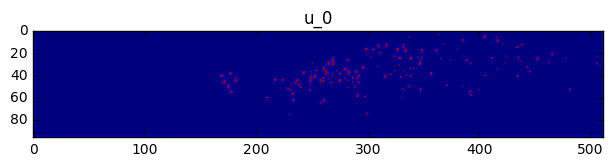

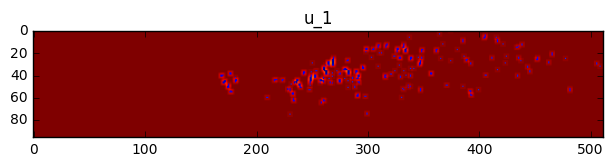

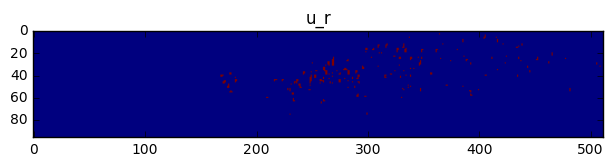

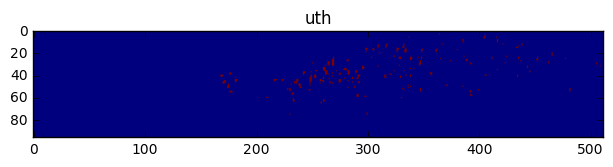

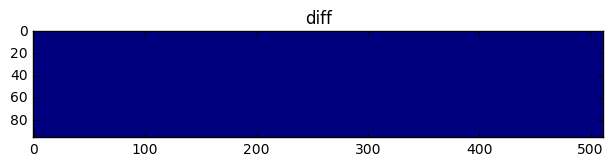

In [6]:
img = imread(image_list[2], as_grey=True)
img = img.astype(np.float64)/255.0
print np.amax(img)

p = 0.552142267288
q = 0.999980269661

p00 = 0.95
p11 = 0.990
alpha = 1
beta = 0.5
n = 5
m = 5

u = 1.0*(img>0.2)
uth = u

print np.amin(u),np.amax(u)
print np.amin(uth),np.amax(uth)

(u_0, u_1) = computeEnergy(u, uth, p, q, p00, p11, alpha, beta, n, m)
print 'u_0:',np.amin(u_0),np.amax(u_0)
print 'u_1:',np.amin(u_1),np.amax(u_1)


plt.figure(figsize=(16,8))
plt.subplot(5,1,1)
plt.imshow(u_0.transpose())#,vmin=0,vmax=255.0)
plt.title('u_0')

plt.figure(figsize=(16,8))
plt.subplot(5,1,2)
plt.imshow(u_1.transpose())#,vmin=0,vmax=255.0)
plt.title('u_1')

u_r = u_1<u_0

plt.figure(figsize=(16,8))
plt.subplot(5,1,3)
plt.imshow(u_r.transpose())#,vmin=0,vmax=255.0)
plt.title('u_r')

plt.figure(figsize=(16,8))
plt.subplot(5,1,4)
plt.imshow(uth.transpose())#,vmin=0,vmax=255.0)
plt.title('uth')

plt.figure(figsize=(16,8))
plt.subplot(5,1,5)
plt.imshow((u_r-uth).transpose())#,vmin=0,vmax=255.0)
plt.title('diff')


47966
1
216
969
p00: 0.995516998049
p11: 0.998969072165
---
48182
0
3
967
p00: 0.999937739961
p11: 1.0
---
48185
0
1
966
p00: 0.999979247084
p11: 1.0
---
48186
0
0
966
p00: 1.0
p11: 1.0
---
48186
0
0
966
p00: 1.0
p11: 1.0
---
48186
0
0
966
p00: 1.0
p11: 1.0
---
48186
0
0
966
p00: 1.0
p11: 1.0
---
48186
0
0
966
p00: 1.0
p11: 1.0
---
48186
0
0
966
p00: 1.0
p11: 1.0
---
48186
0
0
966
p00: 1.0
p11: 1.0
---


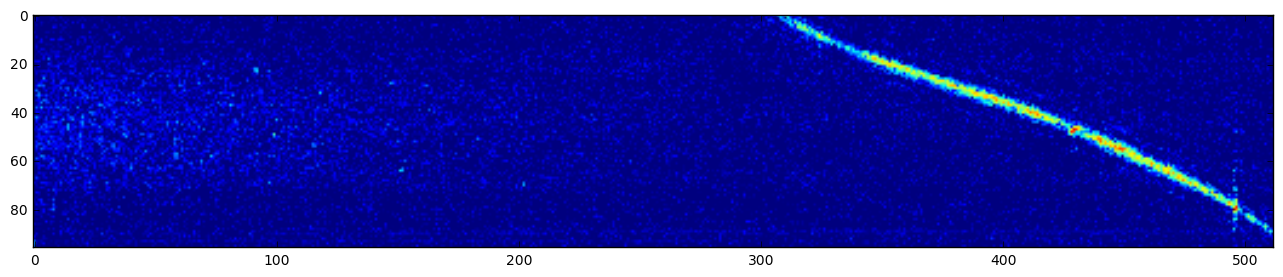

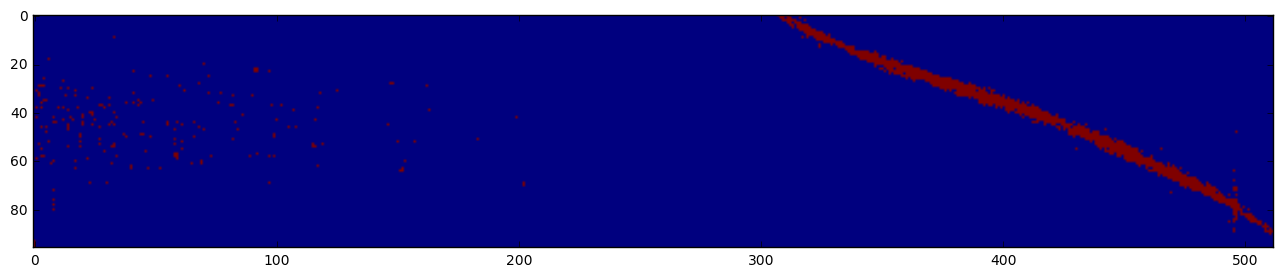

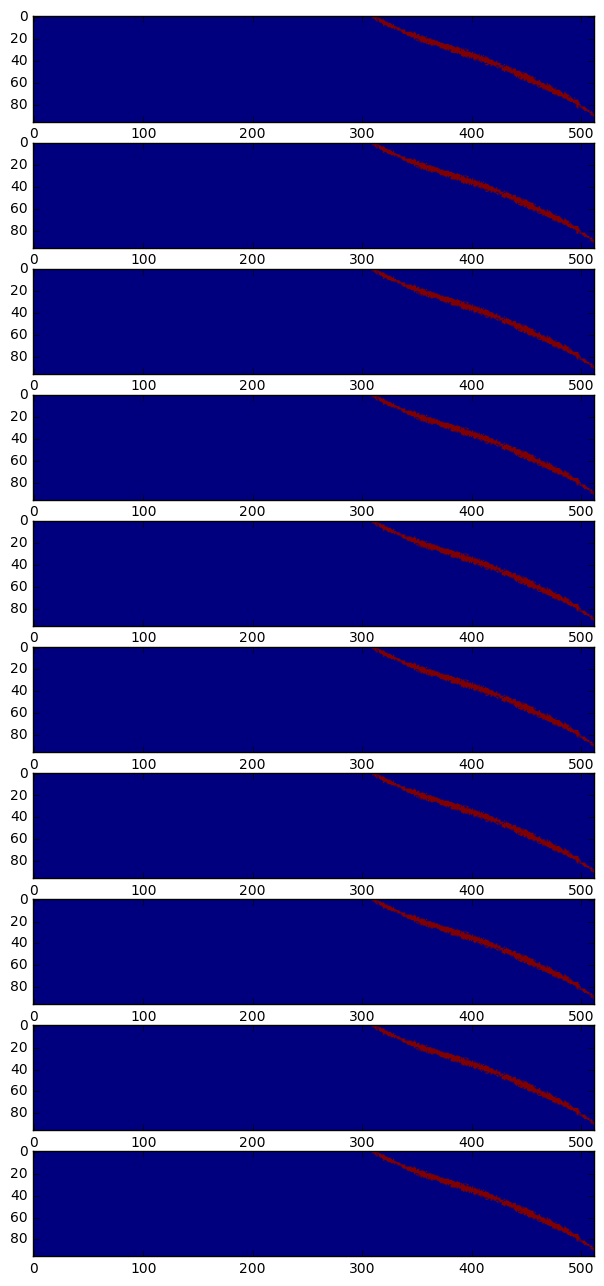

In [7]:
img = imread(image_list[9], as_grey=True)
img = img.astype(np.float64)/255.0

plt.figure(figsize=(16,8))
plt.imshow(img.transpose())

p = 0.9
q = 0.5
p00 = 0.99
p11 = 0.95
alpha = 0.5
beta = 1.0
n = 5
m = 5

u = 1.0*(img>0.1)
uth = u

plt.figure(figsize=(16,8))
plt.imshow(u.transpose())


plt.figure(figsize=(2*16,2*8))
for i in range(1,11):

    u = 1.0*u
    (u_0, u_1) = computeEnergy(u, uth, p, q, p00, p11, alpha, beta, n, m)
    u_prev = (u>0)
    u = (u_1<u_0)
    
    # update transition probability estimates
    n00 = np.sum(1-u[u_prev<1])
    print n00
    n01 = np.sum(u[u_prev<1])
    print n01
    n10 = np.sum(1-u[u_prev])
    print n10
    n11 = np.sum(u[u_prev])
    print n11
    
    p00e = n00/(n00+n10+0.0)
    print 'p00:',p00e
    p11e = n11/(n11+n01+0.0)
    print 'p11:',p11e
    
    assert (n00+n01+n10+n11==49152)
    
    print '---'
    
    plt.subplot(10,1,i)
    plt.imshow((u).transpose())#,vmin=0,vmax=255.0)

plt.show()

In [110]:
# image_list = glob('/home/pvt/Workspace/multibeam-classification/dataset-1/*raw.png') # window set to 2.25m to 11.25m
image_list = glob('/home/pvt/Workspace/multibeam/data/DIDSON/2016-07-19.11/*raw.png') # window set to 2.25m to 11.25m
print len(image_list)

import cv2
from multibeam import Sonar
from didson import Didson

didson = Didson();
didson.loadConfig('data/DIDSON/didson.json')

Resolution
Desired: 0.02 , x: 0.0199847165996 , y: 0.0200030206842
Resolution
Desired: 0.02 , x: 0.019980559264 , y: 0.0200144258506


image: 4729
0.0 0.835294117647
p: 0.648980732699 q: 0.978820889545
n*m-1 14
w neighbors 3.21887582487
neighbors 0.0321887582487
w self 3.83333333333
self 3.83333333333
r+s> 5.06723895421
done in 100 iterations
p00: 0.999813150082
p11: 0.992893401015


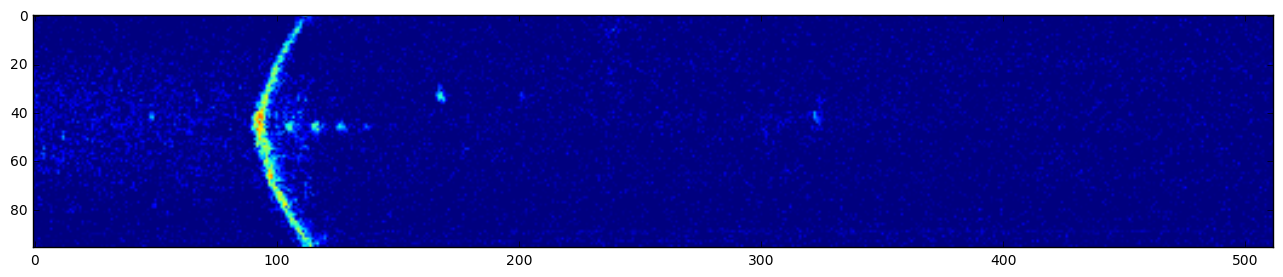

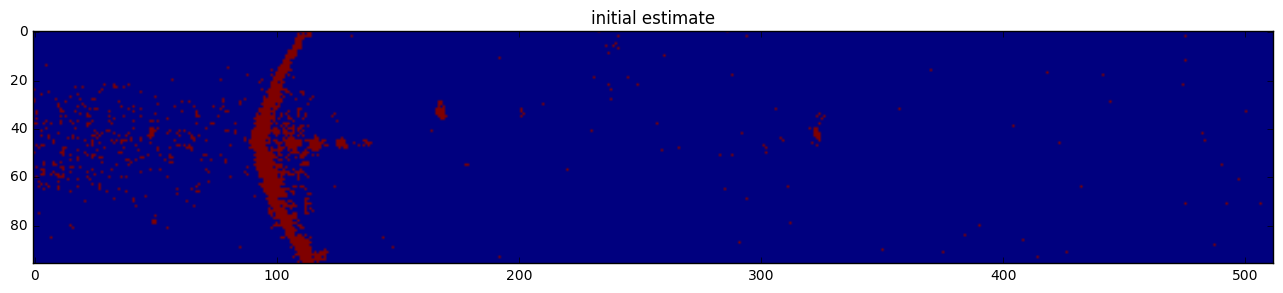

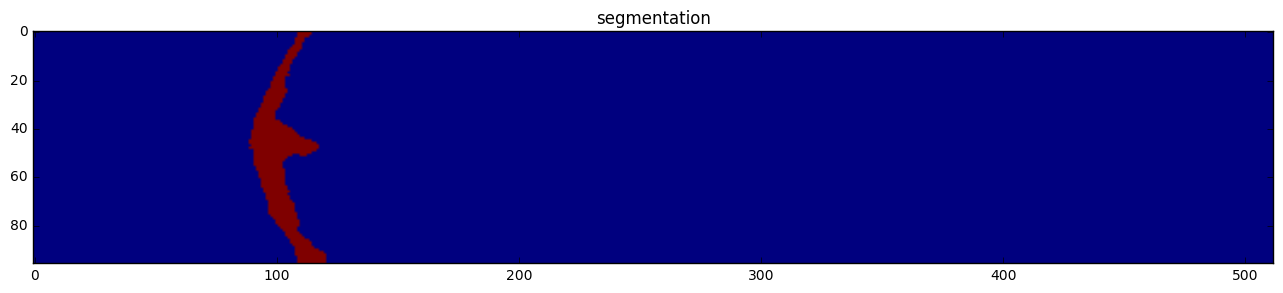

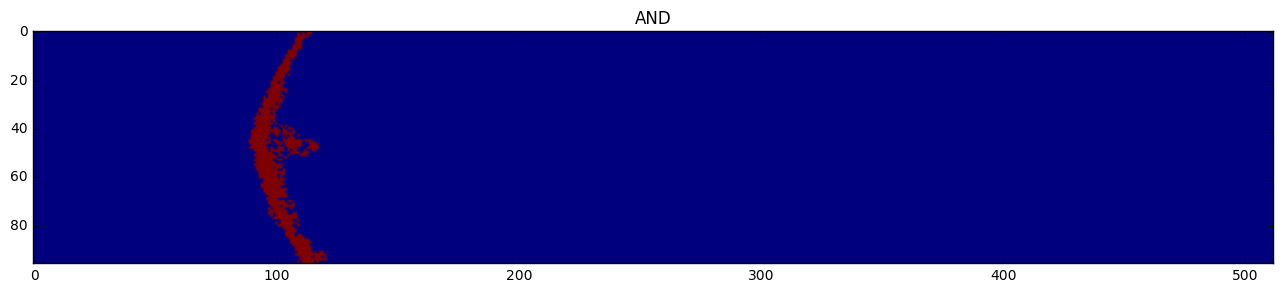

In [217]:
idx = np.random.randint(0,len(image_list))
# idx=30950
print 'image:',idx
# img = imread(image_list[idx], as_grey=True)
ping = cv2.imread(image_list[idx],cv2.CV_LOAD_IMAGE_GRAYSCALE)

img = didson.deconvolve(ping)
img = img.astype(np.float64)/255.0
print np.amin(img), np.amax(img)

plt.figure(figsize=(16,8))
plt.imshow(img.transpose(),vmin=0,vmax=1.0)

p00 = 0.99 # transition 0>0
p11 = 0.25 # transition 1>1

threshold = 23.0
a = expon.cdf(threshold, loc=0, scale=5.0)  # background
b = expon.cdf(threshold, loc=0, scale=30.0) # object
p = a/(a+b)
# p = a
c = 1 - expon.cdf(threshold, loc = 0, scale = 5.0)
d = 1 - expon.cdf(threshold, loc = 0, scale = 30.0)
q = d/(c+d)
# q = d
print 'p:',p, 'q:', q

beta = 1e0
k = 1e-2 # alpha = k*beta

n = 5  # range
m = 3  # bearing

min_size = 0.5*(n*m-1  - (1/beta)*np.log(q/(1-q))  - k*np.log(p11/(1-p00)))
print 'n*m-1',n*m-1
print 'w neighbors',np.log(p11/(1-p00))
print 'neighbors',k*np.log(p11/(1-p00))
print 'w self',np.log(q/(1-q))
print 'self', (1/beta)*np.log(q/(1-q))
print 'r+s>',min_size

uth = (img>(threshold/255.0))
u = 1.0*uth

plt.figure(figsize=(16,8))
plt.imshow(uth.transpose())
plt.title('initial estimate')

plt.figure(figsize=(16,8))
total_change = 10;
iter = 0

pe = np.zeros((100,2))

while (total_change>2):
    
    beta = min(2,beta+0.1)
    alpha = k*beta;
    
    u = 1.0*u
    (u_0, u_1) = computeEnergy(u, uth, p, q, p00, p11, alpha, beta, n, m)
    u_prev = (u>0)
    u = (u_1<u_0)
    
    # transition probability estimates
    n00 = np.sum(1-u[u_prev<1])
    n01 = np.sum(u[u_prev<1])
    n10 = np.sum(1-u[u_prev])
    n11 = np.sum(u[u_prev])
#     print [[n00, n01],[n10, n11]]
#     assert (n00+n,01+n10+n11==49152)
    total_change = n01 + n10
    p00e = n00/(n00+n10+0.0)
    p11e = n11/(n11+n01+0.0)
#     if (p11e > p11):
#         p11 = p11e
    #     p11 = p11e
    pe[iter,0] = p00e
    pe[iter,1] = p11e
    
    iter+=1;
    if iter>=100:
        break
    
print 'done in',iter,'iterations'

print 'p00:',p00e
print 'p11:',p11e

plt.figure(figsize=(16,8))
plt.imshow((u).transpose())#,vmin=0,vmax=255.0)
plt.title('segmentation')


# plt.plot(pe[:iter,0])
# plt.plot(pe[:iter,1])
# plt.legend(('p00','p11'))

plt.figure(figsize=(16,8))
v = np.logical_and(u,uth)
plt.imshow(v.transpose())
plt.title('AND')
plt.show()

In [162]:
u.dtype

dtype('bool')